# Model architecture
ResNet-152

The input images are resized to (channels, x-dim, y-dim) = (3, 224, 224), which is reqiured by the ResNet-152 model.

In [1]:
import os
import numpy as np
from PIL import Image
from torch.utils import data
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.autograd import Variable
import torchvision.transforms as transforms


In [2]:
class Dataset(data.Dataset):
    "Characterizes a dataset for PyTorch"
    def __init__(self, filenames, labels, transform=None):
        "Initialization"
        self.filenames = filenames
        self.labels = labels
        self.transform = transform

    def __len__(self):
        "Denotes the total number of samples"
        return len(self.filenames)


    def __getitem__(self, index):
        "Generates one sample of data"
        # Select sample
        filename = self.filenames[index]
        X = Image.open(filename)

        if self.transform:
            X = self.transform(X)     # transform

        y = torch.LongTensor([self.labels[index]])
        return X, y

## ---------------------- end of Dataloaders ---------------------- ##

In [3]:
def conv2D_output_size(img_size, padding, kernel_size, stride):
    # compute output shape of conv2D
    outshape = (np.floor((img_size[0] + 2 * padding[0] - (kernel_size[0] - 1) - 1) / stride[0] + 1).astype(int),
                np.floor((img_size[1] + 2 * padding[1] - (kernel_size[1] - 1) - 1) / stride[1] + 1).astype(int))
    return outshape

def convtrans2D_output_size(img_size, padding, kernel_size, stride):
    # compute output shape of conv2D
    outshape = ((img_size[0] - 1) * stride[0] - 2 * padding[0] + kernel_size[0],
                (img_size[1] - 1) * stride[1] - 2 * padding[1] + kernel_size[1])
    return outshape

In [4]:
## ---------------------- ResNet VAE ---------------------- ##

class ResNet_VAE(nn.Module):
    def __init__(self, fc_hidden1=1024, fc_hidden2=768, drop_p=0.3, CNN_embed_dim=256):
        super(ResNet_VAE, self).__init__()

        self.fc_hidden1, self.fc_hidden2, self.CNN_embed_dim = fc_hidden1, fc_hidden2, CNN_embed_dim

        # CNN architechtures
        self.ch1, self.ch2, self.ch3, self.ch4 = 16, 32, 64, 128
        self.k1, self.k2, self.k3, self.k4 = (5, 5), (3, 3), (3, 3), (3, 3)      # 2d kernal size
        self.s1, self.s2, self.s3, self.s4 = (2, 2), (2, 2), (2, 2), (2, 2)      # 2d strides
        self.pd1, self.pd2, self.pd3, self.pd4 = (0, 0), (0, 0), (0, 0), (0, 0)  # 2d padding

        # encoding components
        resnet = models.resnet152(pretrained=True)
        modules = list(resnet.children())[:-1]      # delete the last fc layer.
        self.resnet = nn.Sequential(*modules)
        self.fc1 = nn.Linear(resnet.fc.in_features, self.fc_hidden1)
        self.bn1 = nn.BatchNorm1d(self.fc_hidden1, momentum=0.01)
        self.fc2 = nn.Linear(self.fc_hidden1, self.fc_hidden2)
        self.bn2 = nn.BatchNorm1d(self.fc_hidden2, momentum=0.01)
        # Latent vectors mu and sigma
        self.fc3_mu = nn.Linear(self.fc_hidden2, self.CNN_embed_dim)      # output = CNN embedding latent variables
        self.fc3_logvar = nn.Linear(self.fc_hidden2, self.CNN_embed_dim)  # output = CNN embedding latent variables

        # Sampling vector
        self.fc4 = nn.Linear(self.CNN_embed_dim, self.fc_hidden2)
        self.fc_bn4 = nn.BatchNorm1d(self.fc_hidden2)
        self.fc5 = nn.Linear(self.fc_hidden2, 64 * 4 * 4)
        self.fc_bn5 = nn.BatchNorm1d(64 * 4 * 4)
        self.relu = nn.ReLU(inplace=True)

        # Decoder
        self.convTrans6 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=self.k4, stride=self.s4,
                               padding=self.pd4),
            nn.BatchNorm2d(32, momentum=0.01),
            nn.ReLU(inplace=True),
        )
        self.convTrans7 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=8, kernel_size=self.k3, stride=self.s3,
                               padding=self.pd3),
            nn.BatchNorm2d(8, momentum=0.01),
            nn.ReLU(inplace=True),
        )

        self.convTrans8 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=8, out_channels=3, kernel_size=self.k2, stride=self.s2,
                               padding=self.pd2),
            nn.BatchNorm2d(3, momentum=0.01),
            nn.Sigmoid()    # y = (y1, y2, y3) \in [0 ,1]^3
        )


    def encode(self, x):
        x = self.resnet(x)  # ResNet
        x = x.view(x.size(0), -1)  # flatten output of conv

        # FC layers
        x = self.bn1(self.fc1(x))
        x = self.relu(x)
        x = self.bn2(self.fc2(x))
        x = self.relu(x)
        # x = F.dropout(x, p=self.drop_p, training=self.training)
        mu, logvar = self.fc3_mu(x), self.fc3_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        x = self.relu(self.fc_bn4(self.fc4(z)))
        x = self.relu(self.fc_bn5(self.fc5(x))).view(-1, 64, 4, 4)
        x = self.convTrans6(x)
        x = self.convTrans7(x)
        x = self.convTrans8(x)
        x = F.interpolate(x, size=(224, 224), mode='bilinear')
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_reconst = self.decode(z)

        return x_reconst, z, mu, logvar


## Try on 2d Microstructure Data

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
!pip install --upgrade Pillow
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image, ImageFilter
import os
from tqdm import tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
DIR = "drive/MyDrive/2D_less_data/data/"
def multiplicate_data(dir_raw_data):
  dirs = os.listdir(DIR)
  labels = []
  images = []
  for idx in tqdm(range(len(dirs))):
    i = dirs[idx]
    direc = os.path.join(DIR, i)
    list_dir = os.listdir(direc)
    for img_f in list_dir:
      img_path = direc + '/' + img_f
      img_raw = mpimg.imread(img_path).astype(np.uint8)

      img = Image.fromarray(img_raw)
      #img_rotated_cw = img.rotate(15)
      #img_rotated_ccw = img.rotate(-15)
      img_upside_down = img.rotate(180)
      img_90_right = img.rotate(90)
      img_90_left = img.rotate(-90)
      img_flipped_h = img.transpose(method=Image.Transpose.FLIP_LEFT_RIGHT)
      img_flipped_v = img.transpose(method=Image.Transpose.FLIP_TOP_BOTTOM)
      img_blurred = img.filter(filter=ImageFilter.BLUR)
      transformations = [img, 
                         #img_rotated_cw, 
                         #img_rotated_ccw, 
                         img_upside_down,
                          img_90_left, img_90_right, img_flipped_h, 
                          img_flipped_v, img_blurred]
      for pic in transformations:
        # pic = center_crop(pic, 100) # input image dimension
        try:
          images.append(np.array(pic.getdata(), dtype='uint8').reshape(pic.size[0], pic.size[1], 3))
        except ValueError:
          arr = np.repeat(np.array(pic.getdata(), dtype='uint8').reshape(pic.size[0], pic.size[1])[:, :, np.newaxis], 3, axis=2)
          images.append(arr)
      labels.extend([int(i)]*len(transformations))
        
  return images, labels
images, labels = multiplicate_data(DIR)

100%|██████████| 2/2 [00:09<00:00,  4.63s/it]


In [8]:
images = np.array(images)
labels = np.array(labels)

In [9]:
images[0].dtype

dtype('uint8')

In [10]:
import torch
from torch.utils.data import Dataset

class CustomTensorDataset(Dataset):
  def __init__(self, data_X, data_y, transform_list=None):
    X_tensor, y_tensor = torch.tensor(data_X), torch.tensor(data_y)
    tensors = (X_tensor, y_tensor)
    assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
    self.tensors = tensors
    self.data = (data_X, data_y)
    self.transforms = transform_list

  def __getitem__(self, index):
    x = self.data[0][index]

    if self.transforms:
      x = self.transforms(x)

    y = self.tensors[1][index]

    return x, y

  def __len__(self):
    return self.tensors[0].size(0)

In [ ]:
import os
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
import torch.utils.data as data
import torchvision
from torch.autograd import Variable
import matplotlib.pyplot as plt
#from modules import *
from sklearn.model_selection import train_test_split
import pickle
from sklearn.utils import shuffle
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# EncoderCNN architecture
CNN_fc_hidden1, CNN_fc_hidden2 = 1024, 1024
CNN_embed_dim = 256     # latent dim extracted by 2D CNN
res_size = 224        # ResNet image size
dropout_p = 0.2       # dropout probability

# training parameters
epochs = 1000        # training epochs
batch_size = 10
learning_rate = 1e-3
log_interval = 2   # interval for displaying training info


# save model
save_model_path = './results_MNIST'


def check_mkdir(dir_name):
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)

def loss_function(recon_x, x, mu, logvar):
    # MSE = F.mse_loss(recon_x, x, reduction='sum')
    MSE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD


def train(log_interval, model, device, train_loader, optimizer, epoch):
    # set model as training mode
    model.train()

    losses = []
    all_y, all_z, all_mu, all_logvar = [], [], [], []
    N_count = 0   # counting total trained sample in one epoch
    for batch_idx, (X, y) in enumerate(train_loader):
        # distribute data to device
        X, y = X.to(device), y.to(device).view(-1, )
        N_count += X.size(0)

        optimizer.zero_grad()
        X_reconst, z, mu, logvar = model(X)  # VAE
        loss = loss_function(X_reconst, X, mu, logvar)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()

        all_y.extend(y.data.cpu().numpy())
        all_z.extend(z.data.cpu().numpy())
        all_mu.extend(mu.data.cpu().numpy())
        all_logvar.extend(logvar.data.cpu().numpy())

        # show information
        if (batch_idx + 1) % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch + 1, N_count, len(train_loader.dataset), 100. * (batch_idx + 1) / len(train_loader), loss.item()))

    all_y = np.stack(all_y, axis=0)
    all_z = np.stack(all_z, axis=0)
    all_mu = np.stack(all_mu, axis=0)
    all_logvar = np.stack(all_logvar, axis=0)

    # save Pytorch models of best record
    if epoch%100==0:
        torch.save(model.state_dict(), os.path.join(save_model_path, 'model_epoch{}.pth'.format(epoch + 1)))  # save motion_encoder
        torch.save(optimizer.state_dict(), os.path.join(save_model_path, 'optimizer_epoch{}.pth'.format(epoch + 1)))      # save optimizer
        print("Epoch {} model saved!".format(epoch + 1))

    return X.data.cpu().numpy(), all_y, all_z, all_mu, all_logvar, losses


def validation(model, device, optimizer, test_loader):
    # set model as testing mode
    model.eval()

    test_loss = 0
    all_y, all_z, all_mu, all_logvar = [], [], [], []
    with torch.no_grad():
        for X, y in test_loader:
            # distribute data to device
            X, y = X.to(device), y.to(device).view(-1, )
            X_reconst, z, mu, logvar = model(X)

            loss = loss_function(X_reconst, X, mu, logvar)
            test_loss += loss.item()  # sum up batch loss

            all_y.extend(y.data.cpu().numpy())
            all_z.extend(z.data.cpu().numpy())
            all_mu.extend(mu.data.cpu().numpy())
            all_logvar.extend(logvar.data.cpu().numpy())

    test_loss /= len(test_loader.dataset)
    all_y = np.stack(all_y, axis=0)
    all_z = np.stack(all_z, axis=0)
    all_mu = np.stack(all_mu, axis=0)
    all_logvar = np.stack(all_logvar, axis=0)

    # show information
    print('\nTest set ({:d} samples): Average loss: {:.4f}\n'.format(len(test_loader.dataset), test_loss))
    return X.data.cpu().numpy(), all_y, all_z, all_mu, all_logvar, test_loss


# Detect devices
use_cuda = torch.cuda.is_available()                   # check if GPU exists
device = torch.device("cuda" if use_cuda else "cpu")   # use CPU or GPU

# Data loading parameters
params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 4, 'pin_memory': True} if use_cuda else {}
transform = transforms.Compose([transforms.ToPILImage(),
                                transforms.Resize([res_size, res_size]),
                                transforms.ToTensor(),
                                #transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # gray -> GRB 3 channel (lambda function)
                                transforms.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0])])  # for grayscale images

# Load 2D microstructure data
dataset = CustomTensorDataset(images, labels, transform)
train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [int(len(dataset)*0.7), int(len(dataset)) - int(len(dataset)*0.7)])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

# Create model
resnet_vae = ResNet_VAE(fc_hidden1=CNN_fc_hidden1, fc_hidden2=CNN_fc_hidden2, drop_p=dropout_p, CNN_embed_dim=CNN_embed_dim).to(device)
resnet_vae.resnet.requires_grad_(False)
print("Using", torch.cuda.device_count(), "GPU!")
model_params = list(resnet_vae.parameters())
optimizer = torch.optim.Adam(model_params, lr=learning_rate)


# record training process
epoch_train_losses = []
epoch_test_losses = []
check_mkdir(save_model_path)

#start training
for epoch in range(epochs):

    # train, test model
    X_train, y_train, z_train, mu_train, logvar_train, train_losses = train(log_interval, resnet_vae, device, train_loader, optimizer, epoch)
    X_test, y_test, z_test, mu_test, logvar_test, epoch_test_loss = validation(resnet_vae, device, optimizer, valid_loader)

    # save results
    epoch_train_losses.append(train_losses)
    epoch_test_losses.append(epoch_test_loss)

    
    # save all train test results
    A = np.array(epoch_train_losses)
    C = np.array(epoch_test_losses)

    if epoch%100==0:
        np.save(os.path.join(save_model_path, 'ResNet_VAE_training_loss.npy'), A)
        np.save(os.path.join(save_model_path, 'X_MNIST_train_epoch{}.npy'.format(epoch + 1)), X_train) #save last batch
        np.save(os.path.join(save_model_path, 'y_MNIST_train_epoch{}.npy'.format(epoch + 1)), y_train)
        np.save(os.path.join(save_model_path, 'z_MNIST_train_epoch{}.npy'.format(epoch + 1)), z_train)

In [17]:
epoch=999
torch.save(resnet_vae.state_dict(), os.path.join(save_model_path, 'model_epoch{}.pth'.format(epoch + 1)))  # save motion_encoder
torch.save(optimizer.state_dict(), os.path.join(save_model_path, 'optimizer_epoch{}.pth'.format(epoch + 1)))      # save optimizer
print("Epoch {} model saved!".format(epoch + 1))

np.save(os.path.join(save_model_path, 'ResNet_VAE_training_loss.npy'), A)
np.save(os.path.join(save_model_path, 'X_MNIST_train_epoch{}.npy'.format(epoch + 1)), X_train) #save last batch
np.save(os.path.join(save_model_path, 'y_MNIST_train_epoch{}.npy'.format(epoch + 1)), y_train)
np.save(os.path.join(save_model_path, 'z_MNIST_train_epoch{}.npy'.format(epoch + 1)), z_train)

Epoch 1000 model saved!


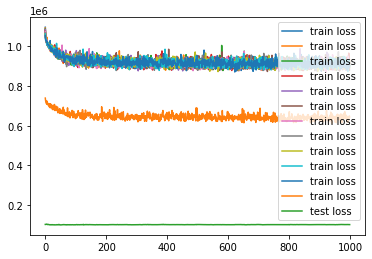

In [13]:
plt.figure()
plt.plot(range(len(epoch_train_losses)), epoch_train_losses, label="train loss")
plt.plot(range(len(epoch_test_losses)), epoch_test_losses, label="test loss")
plt.legend()

In [18]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import os
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
import torch.utils.data as data
import torchvision
from torch.autograd import Variable
import matplotlib.pyplot as plt
#from modules import *
from sklearn.model_selection import train_test_split
import pickle
from sklearn.datasets import fetch_olivetti_faces
from torch.utils.data import Dataset, DataLoader, TensorDataset
from skimage.transform import resize


def decoder(model, device, z):
    model.eval()
    z = Variable(torch.FloatTensor(z)).to(device)
    new_images = model.decode(z).squeeze_().data.cpu().numpy().transpose((1, 2, 0))
    return new_images

#saved_model_path = './results_Olivetti_face'
saved_model_path = './results_MNIST'

#exp = 'Olivetti'
exp = 'MNIST'

# use same ResNet Encoder saved earlier!
CNN_fc_hidden1, CNN_fc_hidden2 = 1024, 1024
CNN_embed_dim = 256
res_size = 224        # ResNet image size
dropout_p = 0.2       # dropout probability

epoch = 1000


use_cuda = torch.cuda.is_available()                   # check if GPU exists
device = torch.device("cuda" if use_cuda else "cpu")   # use CPU or GPU

# reload ResNetVAE model
resnet_vae = ResNet_VAE(fc_hidden1=CNN_fc_hidden1, fc_hidden2=CNN_fc_hidden2, drop_p=dropout_p, CNN_embed_dim=CNN_embed_dim).to(device)
resnet_vae.load_state_dict(torch.load(os.path.join(saved_model_path, 'model_epoch{}.pth'.format(epoch))))

print('ResNetVAE epoch {} model reloaded!'.format(epoch))

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNetVAE epoch 1000 model reloaded!


### Reconstruct Images

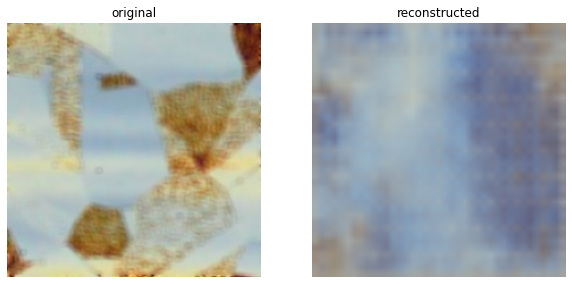

In [34]:
z_train = np.load(os.path.join(saved_model_path, 'z_{}_train_epoch{}.npy').format(exp, epoch))
X_train = np.load(os.path.join(saved_model_path, 'X_{}_train_epoch{}.npy').format(exp, epoch))

ind = 0
zz = torch.from_numpy(z_train[ind]).view(1, -1)
X = np.transpose(X_train[ind], (1, 2, 0))

new_imgs = decoder(resnet_vae, device, zz)

fig = plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.imshow(X)
plt.title('original')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(new_imgs)
plt.title('reconstructed')
plt.axis('off')
plt.savefig("./reconstruction_{}.png".format(exp), bbox_inches='tight', dpi=600)
plt.show()

## Generate Images

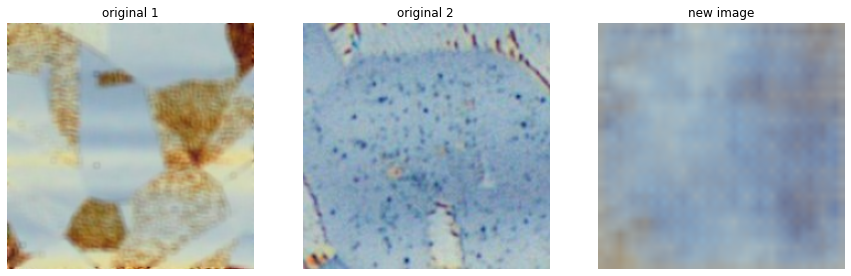

In [38]:
# choose two original images
sample1, sample2 = 0, 5
w = 0.4 # weight for fusing two images

X1 = np.transpose(X_train[-sample1], (1, 2, 0))
X2 = np.transpose(X_train[-sample2], (1, 2, 0))

# generate image using decoder
z_train = np.load(os.path.join(saved_model_path, 'z_{}_train_epoch{}.npy').format(exp, epoch))
z = z_train[-sample1] * w + z_train[-sample2] * (1 - w)
new_imgs = decoder(resnet_vae, device, torch.from_numpy(z).view(1, -1))

fig = plt.figure(figsize=(15, 15))

plt.subplot(1, 3, 1)
plt.imshow(X1)
plt.title('original 1')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(X2)
plt.title('original 2')
plt.axis('off')


plt.subplot(1, 3, 3)
plt.imshow(new_imgs)
plt.title('new image')
plt.axis('off')
plt.savefig("./generated_{}.png".format(exp), bbox_inches='tight', dpi=600)
plt.show()

### Visualize the Latent Space

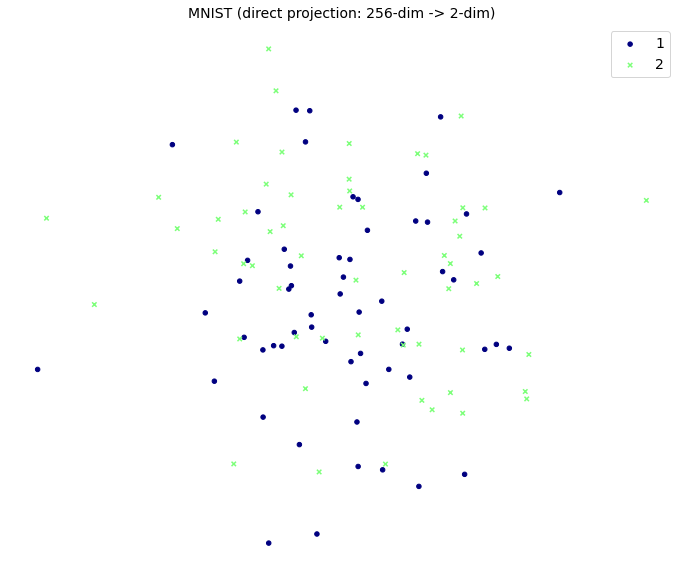

In [46]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
from sklearn.manifold import TSNE
import numpy as np
import pickle

      
epoch = 1000
#exp = 'cifar10'
exp = 'MNIST'

N = 117 # image number

y_train = np.load('./results_{}/y_{}_train_epoch{}.npy'.format(exp, exp, epoch))
z_train = np.load('./results_{}/z_{}_train_epoch{}.npy'.format(exp, exp, epoch))
classes = [1, 2] #MS
y_train = y_train[:N] -1
z_train = z_train[:N]

fig = plt.figure(figsize=(12, 10))
plots = []
markers = ['o', 'x']
for i, c in enumerate(classes):
    ind = (y_train == i).tolist() or ([j < N // len(classes) for j in range(len(y_train))])
    color = cm.jet([i / len(classes)] * sum(ind))
    plots.append(plt.scatter(z_train[ind, 1], z_train[ind, 2], marker=markers[i], c=color, s=20, label=i))

plt.axis('off')
plt.legend(plots, classes, fontsize=14, loc='upper right')
plt.title('{} (direct projection: {}-dim -> 2-dim)'.format(exp, z_train.shape[1]), fontsize=14)
plt.savefig("./ResNetVAE_{}_direct_plot.png".format(exp), bbox_inches='tight', dpi=600)
plt.show()

#### TSNE 2d

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


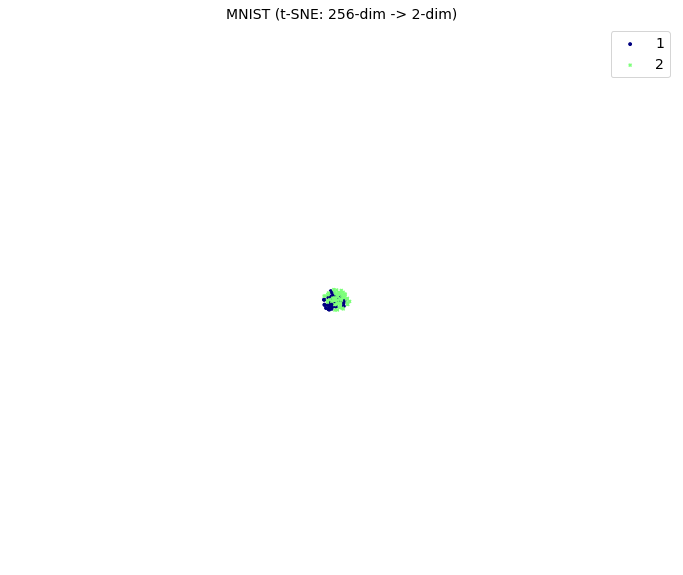

In [47]:
z_embed = TSNE(n_components=2, n_iter=12000).fit_transform(z_train[:N])
fig = plt.figure(figsize=(12, 10))
plots = []
markers = ['o', 'x']  # select different markers
for i, c in enumerate(classes):
    ind = (y_train[:N] == i).tolist()
    color = cm.jet([i / len(classes)] * sum(ind))
    # plot each category one at a time 
    plots.append(plt.scatter(z_embed[ind, 0], z_embed[ind, 1], c=color, marker=markers[i], s=8, label=i))

plt.axis('off')
plt.xlim(-150, 150)
plt.ylim(-150, 150)
plt.legend(plots, classes, fontsize=14, loc='upper right')
plt.title('{} (t-SNE: {}-dim -> 2-dim)'.format(exp, z_train.shape[1]), fontsize=14)
plt.savefig("./ResNetVAE_{}_embedded_plot.png".format(exp), bbox_inches='tight', dpi=600)
plt.show()

#### TSNE 3d

In [ ]:
z_embed3D = TSNE(n_components=3, n_iter=12000).fit_transform(z_train[:N])

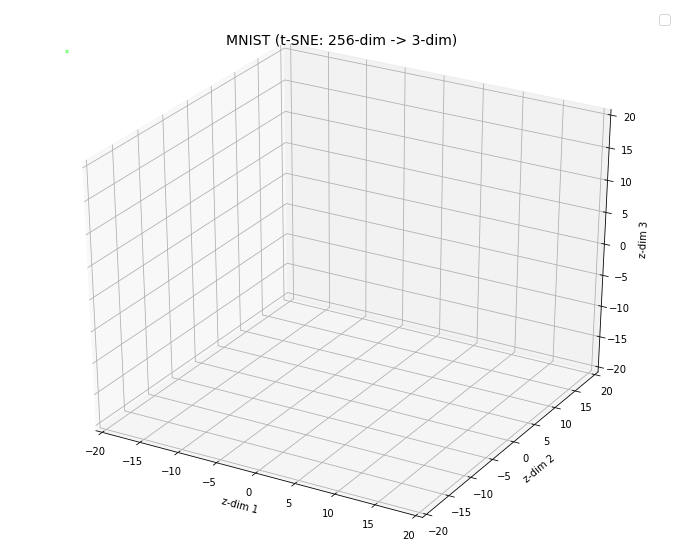

In [50]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

plots = []
markers = ['o', 'x']  # select different markers
for i, c in enumerate(classes):
    ind = (y_train[:N] == i).tolist()
    color = cm.jet([i / len(classes)] * sum(ind))
    # plot each category one at a time 
    ax.scatter(z_embed3D[ind, 0], z_embed3D[ind, 1], c=color, marker=markers[i], s=8, label=i)

ax.axis('on')

r_max = 20
r_min = -r_max

ax.set_xlim(r_min, r_max)
ax.set_ylim(r_min, r_max)
ax.set_zlim(r_min, r_max)
ax.set_xlabel('z-dim 1')
ax.set_ylabel('z-dim 2')
ax.set_zlabel('z-dim 3')
ax.set_title('{} (t-SNE: {}-dim -> 3-dim)'.format(exp, z_train.shape[1]), fontsize=14)
ax.legend(plots, classes, fontsize=14, loc='upper right')
plt.savefig("./ResNetVAE_{}_embedded_3Dplot.png".format(exp), bbox_inches='tight', dpi=600)
plt.show()

# Test on MNIST

In [ ]:
import os
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
import torch.utils.data as data
import torchvision
from torch.autograd import Variable
import matplotlib.pyplot as plt
#from modules import *
from sklearn.model_selection import train_test_split
import pickle

# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# EncoderCNN architecture
CNN_fc_hidden1, CNN_fc_hidden2 = 1024, 1024
CNN_embed_dim = 256     # latent dim extracted by 2D CNN
res_size = 224        # ResNet image size
dropout_p = 0.2       # dropout probability

# training parameters
epochs = 20        # training epochs
batch_size = 50
learning_rate = 1e-3
log_interval = 10   # interval for displaying training info


# save model
save_model_path = './results_MNIST'


def check_mkdir(dir_name):
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)

def loss_function(recon_x, x, mu, logvar):
    # MSE = F.mse_loss(recon_x, x, reduction='sum')
    MSE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD


def train(log_interval, model, device, train_loader, optimizer, epoch):
    # set model as training mode
    model.train()

    losses = []
    all_y, all_z, all_mu, all_logvar = [], [], [], []
    N_count = 0   # counting total trained sample in one epoch
    for batch_idx, (X, y) in enumerate(train_loader):
        # distribute data to device
        X, y = X.to(device), y.to(device).view(-1, )
        N_count += X.size(0)

        optimizer.zero_grad()
        X_reconst, z, mu, logvar = model(X)  # VAE
        loss = loss_function(X_reconst, X, mu, logvar)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()

        all_y.extend(y.data.cpu().numpy())
        all_z.extend(z.data.cpu().numpy())
        all_mu.extend(mu.data.cpu().numpy())
        all_logvar.extend(logvar.data.cpu().numpy())

        # show information
        if (batch_idx + 1) % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch + 1, N_count, len(train_loader.dataset), 100. * (batch_idx + 1) / len(train_loader), loss.item()))

    all_y = np.stack(all_y, axis=0)
    all_z = np.stack(all_z, axis=0)
    all_mu = np.stack(all_mu, axis=0)
    all_logvar = np.stack(all_logvar, axis=0)

    # save Pytorch models of best record
    torch.save(model.state_dict(), os.path.join(save_model_path, 'model_epoch{}.pth'.format(epoch + 1)))  # save motion_encoder
    torch.save(optimizer.state_dict(), os.path.join(save_model_path, 'optimizer_epoch{}.pth'.format(epoch + 1)))      # save optimizer
    print("Epoch {} model saved!".format(epoch + 1))

    return X.data.cpu().numpy(), all_y, all_z, all_mu, all_logvar, losses


def validation(model, device, optimizer, test_loader):
    # set model as testing mode
    model.eval()

    test_loss = 0
    all_y, all_z, all_mu, all_logvar = [], [], [], []
    with torch.no_grad():
        for X, y in test_loader:
            # distribute data to device
            X, y = X.to(device), y.to(device).view(-1, )
            X_reconst, z, mu, logvar = model(X)

            loss = loss_function(X_reconst, X, mu, logvar)
            test_loss += loss.item()  # sum up batch loss

            all_y.extend(y.data.cpu().numpy())
            all_z.extend(z.data.cpu().numpy())
            all_mu.extend(mu.data.cpu().numpy())
            all_logvar.extend(logvar.data.cpu().numpy())

    test_loss /= len(test_loader.dataset)
    all_y = np.stack(all_y, axis=0)
    all_z = np.stack(all_z, axis=0)
    all_mu = np.stack(all_mu, axis=0)
    all_logvar = np.stack(all_logvar, axis=0)

    # show information
    print('\nTest set ({:d} samples): Average loss: {:.4f}\n'.format(len(test_loader.dataset), test_loss))
    return X.data.cpu().numpy(), all_y, all_z, all_mu, all_logvar, test_loss


# Detect devices
use_cuda = torch.cuda.is_available()                   # check if GPU exists
device = torch.device("cuda" if use_cuda else "cpu")   # use CPU or GPU

# Data loading parameters
params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 4, 'pin_memory': True} if use_cuda else {}
transform = transforms.Compose([transforms.Resize([res_size, res_size]),
                                transforms.ToTensor(),
                                transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # gray -> GRB 3 channel (lambda function)
                                transforms.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0])])  # for grayscale images

# MNIST dataset (images and labels)
MNIST_train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
MNIST_test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform)

# Data loader (input pipeline)
train_loader = torch.utils.data.DataLoader(dataset=MNIST_train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=MNIST_test_dataset, batch_size=batch_size, shuffle=False)

# Create model
resnet_vae = ResNet_VAE(fc_hidden1=CNN_fc_hidden1, fc_hidden2=CNN_fc_hidden2, drop_p=dropout_p, CNN_embed_dim=CNN_embed_dim).to(device)
resnet_vae.resnet.requires_grad_(False)
print("Using", torch.cuda.device_count(), "GPU!")
model_params = list(resnet_vae.parameters())
optimizer = torch.optim.Adam(model_params, lr=learning_rate)


# record training process
epoch_train_losses = []
epoch_test_losses = []
check_mkdir(save_model_path)

#start training
for epoch in range(epochs):

    # train, test model
    X_train, y_train, z_train, mu_train, logvar_train, train_losses = train(log_interval, resnet_vae, device, train_loader, optimizer, epoch)
    X_test, y_test, z_test, mu_test, logvar_test, epoch_test_loss = validation(resnet_vae, device, optimizer, valid_loader)

    # save results
    epoch_train_losses.append(train_losses)
    epoch_test_losses.append(epoch_test_loss)

    
    # save all train test results
    A = np.array(epoch_train_losses)
    C = np.array(epoch_test_losses)
    
    np.save(os.path.join(save_model_path, 'ResNet_VAE_training_loss.npy'), A)
    np.save(os.path.join(save_model_path, 'X_MNIST_train_epoch{}.npy'.format(epoch + 1)), X_train) #save last batch
    np.save(os.path.join(save_model_path, 'y_MNIST_train_epoch{}.npy'.format(epoch + 1)), y_train)
    np.save(os.path.join(save_model_path, 'z_MNIST_train_epoch{}.npy'.format(epoch + 1)), z_train)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

Using 1 GPU!
Train Epoch: 1 [500/60000 (1%)]	Loss: 4925737.000000
Train Epoch: 1 [1000/60000 (2%)]	Loss: 4662960.000000
Train Epoch: 1 [1500/60000 (2%)]	Loss: 4517563.500000
Train Epoch: 1 [2000/60000 (3%)]	Loss: 4448750.500000
Train Epoch: 1 [2500/60000 (4%)]	Loss: 4341205.000000
Train Epoch: 1 [3000/60000 (5%)]	Loss: 4238602.500000
Train Epoch: 1 [3500/60000 (6%)]	Loss: 4175650.000000
Train Epoch: 1 [4000/60000 (7%)]	Loss: 4083091.000000
Train Epoch: 1 [4500/60000 (8%)]	Loss: 4078633.250000
Train Epoch: 1 [5000/60000 (8%)]	Loss: 4096816.750000
Train Epoch: 1 [5500/60000 (9%)]	Loss: 3968348.750000
Train Epoch: 1 [6000/60000 (10%)]	Loss: 4066660.000000
Train Epoch: 1 [6500/60000 (11%)]	Loss: 3950097.250000
Train Epoch: 1 [7000/60000 (12%)]	Loss: 3991896.250000
Train Epoch: 1 [7500/60000 (12%)]	Loss: 3868616.250000
Train Epoch: 1 [8000/60000 (13%)]	Loss: 3830856.750000
Train Epoch: 1 [8500/60000 (14%)]	Loss: 3812273.750000
Train Epoch: 1 [9000/60000 (15%)]	Loss: 3792083.500000
Train Epo

KeyboardInterrupt: ignored

# Reconstruction

In [ ]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import os
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
import torch.utils.data as data
import torchvision
from torch.autograd import Variable
import matplotlib.pyplot as plt
#from modules import *
from sklearn.model_selection import train_test_split
import pickle
from sklearn.datasets import fetch_olivetti_faces
from torch.utils.data import Dataset, DataLoader, TensorDataset
from skimage.transform import resize


def decoder(model, device, z):
    model.eval()
    z = Variable(torch.FloatTensor(z)).to(device)
    new_images = model.decode(z).squeeze_().data.cpu().numpy().transpose((1, 2, 0))
    return new_images

#saved_model_path = './results_Olivetti_face'
saved_model_path = './results_MNIST'

#exp = 'Olivetti'
exp = 'MNIST'

# use same ResNet Encoder saved earlier!
CNN_fc_hidden1, CNN_fc_hidden2 = 1024, 1024
CNN_embed_dim = 256
res_size = 224        # ResNet image size
dropout_p = 0.2       # dropout probability

epoch = 8


use_cuda = torch.cuda.is_available()                   # check if GPU exists
device = torch.device("cuda" if use_cuda else "cpu")   # use CPU or GPU

# reload ResNetVAE model
resnet_vae = ResNet_VAE(fc_hidden1=CNN_fc_hidden1, fc_hidden2=CNN_fc_hidden2, drop_p=dropout_p, CNN_embed_dim=CNN_embed_dim).to(device)
resnet_vae.load_state_dict(torch.load(os.path.join(saved_model_path, 'model_epoch{}.pth'.format(epoch))))

print('ResNetVAE epoch {} model reloaded!'.format(epoch))

ResNetVAE epoch 8 model reloaded!


Reconstruct

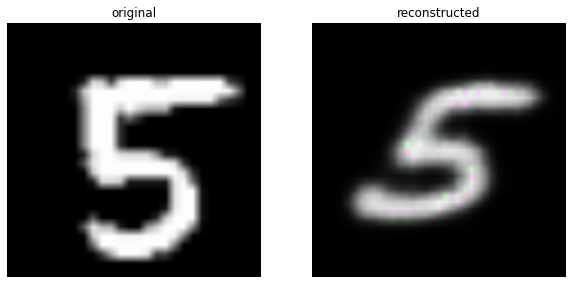

In [ ]:
z_train = np.load(os.path.join(saved_model_path, 'z_{}_train_epoch{}.npy').format(exp, epoch))
X_train = np.load(os.path.join(saved_model_path, 'X_{}_train_epoch{}.npy').format(exp, epoch))

ind = 49
zz = torch.from_numpy(z_train[ind]).view(1, -1)
X = np.transpose(X_train[ind], (1, 2, 0))

new_imgs = decoder(resnet_vae, device, zz)

fig = plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.imshow(X)
plt.title('original')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(new_imgs)
plt.title('reconstructed')
plt.axis('off')
plt.savefig("./reconstruction_{}.png".format(exp), bbox_inches='tight', dpi=600)
plt.show()

Generate new images from latent points

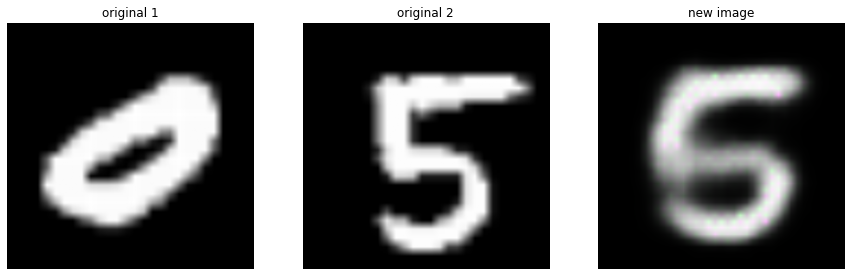

In [ ]:
# choose two original images
sample1, sample2 = 0, 1
w = 0.4 # weight for fusing two images

X1 = np.transpose(X_train[-sample1], (1, 2, 0))
X2 = np.transpose(X_train[-sample2], (1, 2, 0))

# generate image using decoder
z_train = np.load(os.path.join(saved_model_path, 'z_{}_train_epoch{}.npy').format(exp, epoch))
z = z_train[-sample1] * w + z_train[-sample2] * (1 - w)
new_imgs = decoder(resnet_vae, device, torch.from_numpy(z).view(1, -1))

fig = plt.figure(figsize=(15, 15))

plt.subplot(1, 3, 1)
plt.imshow(X1)
plt.title('original 1')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(X2)
plt.title('original 2')
plt.axis('off')


plt.subplot(1, 3, 3)
plt.imshow(new_imgs)
plt.title('new image')
plt.axis('off')
plt.savefig("./generated_{}.png".format(exp), bbox_inches='tight', dpi=600)
plt.show()

# plot latent

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
from sklearn.manifold import TSNE
import numpy as np
import pickle

      
epoch = 7
#exp = 'cifar10'
exp = 'MNIST'

N = 6000 # image number

y_train = np.load('./results_{}/y_{}_train_epoch{}.npy'.format(exp, exp, epoch))
z_train = np.load('./results_{}/z_{}_train_epoch{}.npy'.format(exp, exp, epoch))
#classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']  # cifar10
classes = np.arange(10) #MNIST

Direct projection of latent space


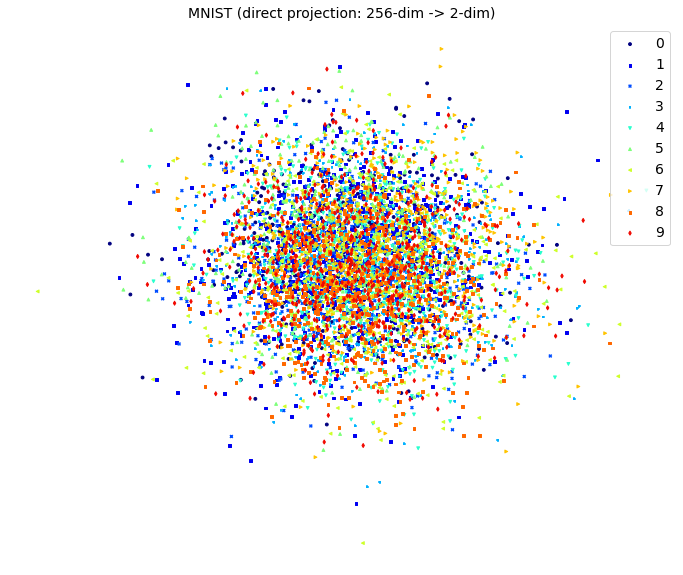

In [ ]:
y_train = y_train[:N]
z_train = z_train[:N]

fig = plt.figure(figsize=(12, 10))
plots = []
markers = ['o', ',', 'x', '+', 'v', '^', '<', '>', 's', 'd']
for i, c in enumerate(classes):
    ind = (y_train == i).tolist() or ([j < N // len(classes) for j in range(len(y_train))])
    color = cm.jet([i / len(classes)] * sum(ind))
    plots.append(plt.scatter(z_train[ind, 1], z_train[ind, 2], marker=markers[i], c=color, s=8, label=i))

plt.axis('off')
plt.legend(plots, classes, fontsize=14, loc='upper right')
plt.title('{} (direct projection: {}-dim -> 2-dim)'.format(exp, z_train.shape[1]), fontsize=14)
plt.savefig("./ResNetVAE_{}_direct_plot.png".format(exp), bbox_inches='tight', dpi=600)
plt.show()

use t-sne for dimension reduction

compressed to 2-dimensions

In [ ]:
z_embed = TSNE(n_components=2, n_iter=12000).fit_transform(z_train[:N])


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


KeyboardInterrupt: ignored

In [ ]:
fig = plt.figure(figsize=(12, 10))
plots = []
markers = ['o', ',', 'x', '+', 'v', '^', '<', '>', 's', 'd']  # select different markers
for i, c in enumerate(classes):
    ind = (y_train[:N] == i).tolist()
    color = cm.jet([i / len(classes)] * sum(ind))
    # plot each category one at a time 
    plots.append(plt.scatter(z_embed[ind, 0], z_embed[ind, 1], c=color, marker=markers[i], s=8, label=i))

plt.axis('off')
plt.xlim(-150, 150)
plt.ylim(-150, 150)
plt.legend(plots, classes, fontsize=14, loc='upper right')
plt.title('{} (t-SNE: {}-dim -> 2-dim)'.format(exp, z_train.shape[1]), fontsize=14)
plt.savefig("./ResNetVAE_{}_embedded_plot.png".format(exp), bbox_inches='tight', dpi=600)
plt.show()

compressed to 3-dimensions

In [ ]:
z_embed3D = TSNE(n_components=3, n_iter=12000).fit_transform(z_train[:N])


In [ ]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

plots = []
markers = ['o', ',', 'x', '+', 'v', '^', '<', '>', 's', 'd']  # select different markers
for i, c in enumerate(classes):
    ind = (y_train[:N] == i).tolist()
    color = cm.jet([i / len(classes)] * sum(ind))
    # plot each category one at a time 
    ax.scatter(z_embed3D[ind, 0], z_embed3D[ind, 1], c=color, marker=markers[i], s=8, label=i)

ax.axis('on')

r_max = 20
r_min = -r_max

ax.set_xlim(r_min, r_max)
ax.set_ylim(r_min, r_max)
ax.set_zlim(r_min, r_max)
ax.set_xlabel('z-dim 1')
ax.set_ylabel('z-dim 2')
ax.set_zlabel('z-dim 3')
ax.set_title('{} (t-SNE: {}-dim -> 3-dim)'.format(exp, z_train.shape[1]), fontsize=14)
ax.legend(plots, classes, fontsize=14, loc='upper right')
plt.savefig("./ResNetVAE_{}_embedded_3Dplot.png".format(exp), bbox_inches='tight', dpi=600)
plt.show()

# Test on Cifar-10

In [ ]:
import os
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
import torch.utils.data as data
import torchvision
from torch.autograd import Variable
import matplotlib.pyplot as plt
#from modules import *
from sklearn.model_selection import train_test_split
import pickle

# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# EncoderCNN architecture
CNN_fc_hidden1, CNN_fc_hidden2 = 1024, 1024
CNN_embed_dim = 256     # latent dim extracted by 2D CNN
res_size = 224        # ResNet image size
dropout_p = 0.2       # dropout probability


# training parameters
epochs = 20        # training epochs
batch_size = 50
learning_rate = 1e-3
log_interval = 10   # interval for displaying training info

# save model
save_model_path = './results_cifar10'

def check_mkdir(dir_name):
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)


def loss_function(recon_x, x, mu, logvar):
    # MSE = F.mse_loss(recon_x, x, reduction='sum')
    MSE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD


def train(log_interval, model, device, train_loader, optimizer, epoch):
    # set model as training mode
    model.train()

    losses = []
    all_y, all_z, all_mu, all_logvar = [], [], [], []
    N_count = 0   # counting total trained sample in one epoch
    for batch_idx, (X, y) in enumerate(train_loader):
        # distribute data to device
        X, y = X.to(device), y.to(device).view(-1, )
        N_count += X.size(0)

        optimizer.zero_grad()
        X_reconst, z, mu, logvar = model(X)  # VAE
        loss = loss_function(X_reconst, X, mu, logvar)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()

        all_y.extend(y.data.cpu().numpy())
        all_z.extend(z.data.cpu().numpy())
        all_mu.extend(mu.data.cpu().numpy())
        all_logvar.extend(logvar.data.cpu().numpy())

        # show information
        if (batch_idx + 1) % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch + 1, N_count, len(train_loader.dataset), 100. * (batch_idx + 1) / len(train_loader), loss.item()))

    all_y = np.stack(all_y, axis=0)
    all_z = np.stack(all_z, axis=0)
    all_mu = np.stack(all_mu, axis=0)
    all_logvar = np.stack(all_logvar, axis=0)

    # save Pytorch models of best record
    torch.save(model.state_dict(), os.path.join(save_model_path, 'model_epoch{}.pth'.format(epoch + 1)))  # save motion_encoder
    torch.save(optimizer.state_dict(), os.path.join(save_model_path, 'optimizer_epoch{}.pth'.format(epoch + 1)))      # save optimizer
    print("Epoch {} model saved!".format(epoch + 1))

    return X_reconst.data.cpu().numpy(), all_y, all_z, all_mu, all_logvar, losses


def validation(model, device, optimizer, test_loader):
    # set model as testing mode
    model.eval()

    test_loss = 0
    all_y, all_z, all_mu, all_logvar = [], [], [], []
    with torch.no_grad():
        for X, y in test_loader:
            # distribute data to device
            X, y = X.to(device), y.to(device).view(-1, )
            X_reconst, z, mu, logvar = model(X)

            loss = loss_function(X_reconst, X, mu, logvar)
            test_loss += loss.item()  # sum up batch loss

            all_y.extend(y.data.cpu().numpy())
            all_z.extend(z.data.cpu().numpy())
            all_mu.extend(mu.data.cpu().numpy())
            all_logvar.extend(logvar.data.cpu().numpy())

    test_loss /= len(test_loader.dataset)
    all_y = np.stack(all_y, axis=0)
    all_z = np.stack(all_z, axis=0)
    all_mu = np.stack(all_mu, axis=0)
    all_logvar = np.stack(all_logvar, axis=0)

    # show information
    print('\nTest set ({:d} samples): Average loss: {:.4f}\n'.format(len(test_loader.dataset), test_loss))
    return X_reconst.data.cpu().numpy(), all_y, all_z, all_mu, all_logvar, test_loss


# Detect devices
use_cuda = torch.cuda.is_available()                   # check if GPU exists
device = torch.device("cuda" if use_cuda else "cpu")   # use CPU or GPU

# Data loading parameters
params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True} if use_cuda else {}
# transform = transforms.Compose([transforms.Resize([res_size, res_size]),
#                                 transforms.ToTensor(),
#                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

transform = transforms.Compose([transforms.Resize([res_size, res_size]),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0])])

# cifar10 dataset (images and labels)
cifar10_train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
cifar10_test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


# classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Data loader (input pipeline)
train_loader = torch.utils.data.DataLoader(dataset=cifar10_train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=cifar10_test_dataset, batch_size=batch_size, shuffle=False)

# Create model
resnet_vae = ResNet_VAE(fc_hidden1=CNN_fc_hidden1, fc_hidden2=CNN_fc_hidden2, drop_p=dropout_p, CNN_embed_dim=CNN_embed_dim).to(device)

print("Using", torch.cuda.device_count(), "GPU!")
model_params = list(resnet_vae.parameters())
optimizer = torch.optim.Adam(model_params, lr=learning_rate)


# record training process
epoch_train_losses = []
epoch_test_losses = []
check_mkdir(save_model_path)

# start training
for epoch in range(epochs):
    # train, test model
    X_reconst_train, y_train, z_train, mu_train, logvar_train, train_losses = train(log_interval, resnet_vae, device, train_loader, optimizer, epoch)
    X_reconst_test, y_test, z_test, mu_test, logvar_test, epoch_test_loss = validation(resnet_vae, device, optimizer, valid_loader)

    # save results
    epoch_train_losses.append(train_losses)
    epoch_test_losses.append(epoch_test_loss)

    # save all train test results
    A = np.array(epoch_train_losses)
    C = np.array(epoch_test_losses)
    
    np.save(os.path.join(save_model_path, 'ResNet_VAE_training_loss.npy'), A)
    np.save(os.path.join(save_model_path, 'y_cifar10_train_epoch{}.npy'.format(epoch + 1)), y_train)
    np.save(os.path.join(save_model_path, 'z_cifar10_train_epoch{}.npy'.format(epoch + 1)), z_train)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using 1 GPU!
Train Epoch: 1 [500/50000 (1%)]	Loss: 5235931.000000
Train Epoch: 1 [1000/50000 (2%)]	Loss: 5136163.000000
Train Epoch: 1 [1500/50000 (3%)]	Loss: 5064313.000000
Train Epoch: 1 [2000/50000 (4%)]	Loss: 4992495.500000
Train Epoch: 1 [2500/50000 (5%)]	Loss: 4964986.000000
Train Epoch: 1 [3000/50000 (6%)]	Loss: 4853477.500000
Train Epoch: 1 [3500/50000 (7%)]	Loss: 4850918.000000
Train Epoch: 1 [4000/50000 (8%)]	Loss: 4893091.500000
Train Epoch: 1 [4500/50000 (9%)]	Loss: 4660957.000000
Train Epoch: 1 [5000/50000 (10%)]	Loss: 4771959.500000
Train Epoch: 1 [5500/50000 (11%)]	Loss: 4864060.500000
Train Epoch: 1 [6000/50000 (12%)]	Loss: 4850434.000000
Train Epoch: 1 [6500/50000 (13%)]	Loss: 4733037.500000
Train Epoch: 1 [7000/50000 (14%)]	Loss: 4681704.500000
Train Epoch: 1 [7500/50000 (15%)]	Loss: 4651012.500000
Train Epoch: 1 [8000/50000 (16%)]	Loss: 4682382.000000
Train Epoch: 1 [8500/50000 (17%)]	Loss: 4781784.500000
Train Epoch: 1 [9000/50000 (18%)]	Loss: 4611211.500000
Train E

# test on Face

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
import torch.utils.data as data
import torchvision
from torch.autograd import Variable
import matplotlib.pyplot as plt
from modules import *
from sklearn.datasets import fetch_olivetti_faces
from torch.utils.data import Dataset, DataLoader, TensorDataset
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import pickle

# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# EncoderCNN architecture
CNN_fc_hidden1, CNN_fc_hidden2 = 1024, 1024
CNN_embed_dim = 256     # latent dim extracted by 2D CNN
res_size = 224        # ResNet image size
dropout_p = 0.2       # dropout probability


# training parameters
epochs = 100        # training epochs
batch_size = 50
learning_rate = 1e-3
log_interval = 10   # interval for displaying training info

# save model
save_model_path = './results_Olivetti_face'

def check_mkdir(dir_name):
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)


def loss_function(recon_x, x, mu, logvar):
    # MSE = F.mse_loss(recon_x, x, reduction='sum')
    MSE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD


def train(log_interval, model, device, train_loader, optimizer, epoch):
    # set model as training mode
    model.train()

    losses = []
    all_X, all_y, all_z, all_mu, all_logvar = [], [], [], [], []
    N_count = 0   # counting total trained sample in one epoch
    for batch_idx, (X, y) in enumerate(train_loader):
        # distribute data to device
        X, y = X.to(device), y.to(device).view(-1, )
        N_count += X.size(0)

        optimizer.zero_grad()
        X_reconst, z, mu, logvar = model(X)  # VAE
        loss = loss_function(X_reconst, X, mu, logvar)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        
        all_X.extend(X.data.cpu().numpy())
        all_y.extend(y.data.cpu().numpy())
        all_z.extend(z.data.cpu().numpy())
        all_mu.extend(mu.data.cpu().numpy())
        all_logvar.extend(logvar.data.cpu().numpy())

        # show information
        if (batch_idx + 1) % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch + 1, N_count, len(train_loader.dataset), 100. * (batch_idx + 1) / len(train_loader), loss.item()))
    
    all_X = np.stack(all_X, axis=0)
    all_y = np.stack(all_y, axis=0)
    all_z = np.stack(all_z, axis=0)
    all_mu = np.stack(all_mu, axis=0)
    all_logvar = np.stack(all_logvar, axis=0)

    # save Pytorch models of best record
    torch.save(model.state_dict(), os.path.join(save_model_path, 'model_epoch{}.pth'.format(epoch + 1)))  # save motion_encoder
    torch.save(optimizer.state_dict(), os.path.join(save_model_path, 'optimizer_epoch{}.pth'.format(epoch + 1)))      # save optimizer
    print("Epoch {} model saved!".format(epoch + 1))

    return all_X, all_y, all_z, all_mu, all_logvar, losses


def validation(model, device, optimizer, test_loader):
    # set model as testing mode
    model.eval()

    test_loss = 0
    all_X, all_y, all_z, all_mu, all_logvar = [], [], [], [], []
    with torch.no_grad():
        for X, y in test_loader:
            # distribute data to device
            X, y = X.to(device), y.to(device).view(-1, )
            X_reconst, z, mu, logvar = model(X)

            loss = loss_function(X_reconst, X, mu, logvar)
            test_loss += loss.item()  # sum up batch loss

            all_X.extend(X.data.cpu().numpy())
            all_y.extend(y.data.cpu().numpy())
            all_z.extend(z.data.cpu().numpy())
            all_mu.extend(mu.data.cpu().numpy())
            all_logvar.extend(logvar.data.cpu().numpy())

    test_loss /= len(test_loader.dataset)
    all_X = np.stack(all_X, axis=0)
    all_y = np.stack(all_y, axis=0)
    all_z = np.stack(all_z, axis=0)
    all_mu = np.stack(all_mu, axis=0)
    all_logvar = np.stack(all_logvar, axis=0)

    # show information
    print('\nTest set ({:d} samples): Average loss: {:.4f}\n'.format(len(test_loader.dataset), test_loss))
    return all_X, all_y, all_z, all_mu, all_logvar, test_loss


# Detect devices
use_cuda = torch.cuda.is_available()                   # check if GPU exists
device = torch.device("cuda" if use_cuda else "cpu")   # use CPU or GPU

# Data loading parameters
params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True} if use_cuda else {}


# Load the faces datasets
data = fetch_olivetti_faces()
face_img = data.images.reshape((data.images.shape[0], data.images.shape[1], data.images.shape[2]))
face_img_resized = [np.tile(np.expand_dims(resize(face_img[i, :, :], (res_size, res_size), anti_aliasing=True), axis=0), (3, 1, 1)) for i in range(face_img.shape[0])]
face_img_resized = np.stack(face_img_resized, axis=0)
face_img_resized = torch.from_numpy(face_img_resized).float()
labels = torch.from_numpy(data.target)

olivetti_data = TensorDataset(face_img_resized, labels)
# Data loader (input pipeline)
train_loader = torch.utils.data.DataLoader(dataset=olivetti_data, **params)
valid_loader = torch.utils.data.DataLoader(dataset=olivetti_data, **params)

# Create model
resnet_vae = ResNet_VAE(fc_hidden1=CNN_fc_hidden1, fc_hidden2=CNN_fc_hidden2, drop_p=dropout_p, CNN_embed_dim=CNN_embed_dim).to(device)

print("Using", torch.cuda.device_count(), "GPU!")
model_params = list(resnet_vae.parameters())
optimizer = torch.optim.Adam(model_params, lr=learning_rate)


# record training process
epoch_train_losses = []
epoch_test_losses = []
check_mkdir(save_model_path)

# start training
for epoch in range(epochs):
    # train, test model
    X_train, y_train, z_train, mu_train, logvar_train, train_losses = train(log_interval, resnet_vae, device, train_loader, optimizer, epoch)
    X_test, y_test, z_test, mu_test, logvar_test, epoch_test_loss = validation(resnet_vae, device, optimizer, valid_loader)

    # save results
    epoch_train_losses.append(train_losses)
    epoch_test_losses.append(epoch_test_loss)

    # save all train test results
    A = np.array(epoch_train_losses)
    C = np.array(epoch_test_losses)
    
    np.save(os.path.join(save_model_path, 'ResNet_VAE_training_loss.npy'), A)
    np.save(os.path.join(save_model_path, 'X_Olivetti_train_epoch{}.npy'.format(epoch + 1)), X_train)
    np.save(os.path.join(save_model_path, 'y_Olivetti_train_epoch{}.npy'.format(epoch + 1)), y_train)
    np.save(os.path.join(save_model_path, 'z_Olivetti_train_epoch{}.npy'.format(epoch + 1)), z_train)